## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95
save_best_only = [True, False]

In [11]:
from keras.callbacks import ModelCheckpoint

results = {}
for save_best in save_best_only:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    filename = "tmp_save_best_" + str(save_best)
    temp_path = os.path.join("./", filename)
    model_ckpt = ModelCheckpoint(filepath=temp_path, 
                                 monitor="val_loss", 
                                 save_best_only=save_best)
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[model_ckpt]
             )

# Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]

    tag_name = "save_best_" + str(save_best)
    results[tag_name] = {'train-loss': train_loss,
                        'valid-loss': valid_loss,
                        'train-acc': train_acc,
                        'valid-acc': valid_acc}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

50000/50000 [==============================] - 9s 173us/step - loss: 0.5153 - acc: 0.8548 - val_loss: 1.6818 - val_acc: 0.4881
Epoch 50/50
50000/50000 [==============================] - 9s 173us/step - loss: 0.4980 - acc: 0.8609 - val_loss: 1.6926 - val_acc: 0.4850
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
________

50000/50000 [==============================] - 9s 181us/step - loss: 0.5236 - acc: 0.8508 - val_loss: 1.6668 - val_acc: 0.4928
Epoch 48/50
50000/50000 [==============================] - 9s 183us/step - loss: 0.5047 - acc: 0.8580 - val_loss: 1.6708 - val_acc: 0.4903
Epoch 49/50
50000/50000 [==============================] - 9s 183us/step - loss: 0.4897 - acc: 0.8633 - val_loss: 1.6850 - val_acc: 0.4869
Epoch 50/50
50000/50000 [==============================] - 9s 182us/step - loss: 0.4723 - acc: 0.8715 - val_loss: 1.7124 - val_acc: 0.4836


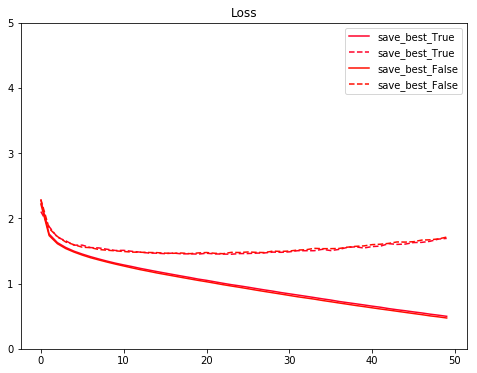

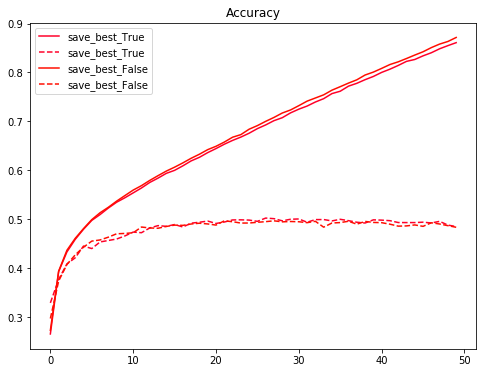

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.cm as mplcm
import matplotlib.colors as colors
NUM_COLORS = 25

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [15]:
# Load back
model1 = keras.models.load_model("./tmp_save_best_True")
model2 = keras.models.load_model("./tmp_save_best_False")
loss_loadback1, acc_loadback1 = model1.evaluate(x_test, y_test)
loss_loadback2, acc_loadback2 = model2.evaluate(x_test, y_test)

10000/10000 [==============================] - 2s 190us/step


In [17]:
print("loss1 = %.2f, acc1 = %.2f" %(loss_loadback1, acc_loadback1))
print("loss2 = %.2f, acc2 = %.2f" %(loss_loadback2, acc_loadback2))

loss1 = 1.45, acc1 = 0.50
loss2 = 1.71, acc2 = 0.48
